In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#memory that we can use
!free -h --si | awk  '/Mem:/{print $2}'

26G


In [ ]:
!pip install spectral

In [ ]:
import keras
from keras.layers import Input
#from tensorflow.keras.optimizers import Adam
from keras.layers import Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization
from keras.layers import Dropout,AveragePooling2D
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score

from operator import truediv

from plotly.offline import init_notebook_mode

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os
import spectral

from skimage import feature
from keras.layers import Concatenate, Lambda
init_notebook_mode(connected=True)
%matplotlib inline

In [ ]:
## GLOBAL VARIABLES
dataset = 'IP'
test_ratio = 0.7
windowSize = 25

In [ ]:
def loadData(name):
    data_path = os.path.join(os.getcwd(),'/content/drive/My Drive/data/')
    if name == 'IP':
        data = sio.loadmat(os.path.join(data_path, 'Indian_pines_corrected.mat'))['indian_pines_corrected']
        labels = sio.loadmat(os.path.join(data_path, 'Indian_pines_gt.mat'))['indian_pines_gt']
    elif name == 'SA':
        data = sio.loadmat(os.path.join(data_path, 'Salinas_corrected.mat'))['salinas_corrected']
        labels = sio.loadmat(os.path.join(data_path, 'Salinas_gt.mat'))['salinas_gt']
    elif name == 'PU':
        data = sio.loadmat(os.path.join(data_path, 'PaviaU.mat'))['paviaU']
        labels = sio.loadmat(os.path.join(data_path, 'PaviaU_gt.mat'))['paviaU_gt']
    
    return data, labels

In [ ]:
def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test

In [ ]:
def applyPCA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

In [ ]:
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

In [ ]:
def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

In [ ]:
from scipy.fftpack import dct,idct
def dctn(X, norm='ortho'):
  for i in range (X.ndim):
    X=dct(X, axis=i, norm=norm)
  return X

In [ ]:
X, y = loadData(dataset)
X.shape, y.shape

((145, 145, 200), (145, 145))

In [ ]:
K = 15 if dataset == 'IP' else 10
X,pca = applyPCA(X,numComponents=K)

X.shape

(145, 145, 15)

In [ ]:
#Binarization of image
X1=np.zeros(X.shape)
X1[:,:,:]=X[:,:,:]
bimage = (255*(X1 - np.min(X1))/np.ptp(X1)).astype(int)   
th=np.sum(bimage)//(145*145*15)
bimage= np.where(bimage >= th, 1, 0)

for i in range(15):
  Xtemp = bimage[:,:,i]
  (hog_desc, hog_image) = feature.hog(Xtemp, orientations=9, pixels_per_cell=(2, 2),
                                      cells_per_block=(8, 8), transform_sqrt=True, block_norm='L2-Hys', visualize=True)
  hog_image_temp=np.reshape(hog_image, (145, 145 , 1))
  X = np.concatenate((X, hog_image_temp), axis=2)
  print(hog_image_temp.shape,X.shape)

#import matplotlib.pyplot as plt
#_, axes = plt.subplots(2, 5, figsize=(30,20))
#axes = axes.flatten()
#for i in range(10):
#  axes[i].imshow(bimage[:,:,i])

(145, 145, 1) (145, 145, 16)
(145, 145, 1) (145, 145, 17)
(145, 145, 1) (145, 145, 18)
(145, 145, 1) (145, 145, 19)
(145, 145, 1) (145, 145, 20)
(145, 145, 1) (145, 145, 21)
(145, 145, 1) (145, 145, 22)
(145, 145, 1) (145, 145, 23)
(145, 145, 1) (145, 145, 24)
(145, 145, 1) (145, 145, 25)
(145, 145, 1) (145, 145, 26)
(145, 145, 1) (145, 145, 27)
(145, 145, 1) (145, 145, 28)
(145, 145, 1) (145, 145, 29)
(145, 145, 1) (145, 145, 30)


In [ ]:
#import matplotlib.pyplot as plt
#_, axes = plt.subplots(4, 5, figsize=(30,20))
#axes = axes.flatten()
#for i in range(20):
#  axes[i].imshow(X[:,:,i])

In [ ]:
X.shape

(145, 145, 30)

In [ ]:
X, y = createImageCubes(X, y, windowSize=windowSize)

X.shape, y.shape

((10249, 25, 25, 30), (10249,))

In [ ]:
test=np.zeros((X.shape[:3]))
test=X[:,:,:,0:15]
test.shape

(10249, 25, 25, 15)

In [ ]:
#DCT of image
for i in range(test.shape[0]):
  test[i]=dctn(test[i])
  #print(i)
  
#test = test.reshape(-1, windowSize, windowSize, 15, 1)
test.shape

(10249, 25, 25, 15)

In [ ]:
X[:,:,:,0:15]=test[:,:,:,:]
#Xtrain= np.concatenate((Xtrain, test), axis=3)
X.shape

(10249, 25, 25, 30)

In [ ]:
#plt.imshow(Xtrain[0,:,:,8,0])
#import matplotlib.pyplot as plt
#_, axes = plt.subplots(4, 5, figsize=(30,20))
#axes = axes.flatten()
#for i in range(20):
#    axes[i].imshow(X[1000,:,:,i])

In [ ]:
Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(X, y, test_ratio)

Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((3074, 25, 25, 30), (7175, 25, 25, 30), (3074,), (7175,))

In [ ]:
Xtrain = Xtrain.reshape(-1, windowSize, windowSize, 30, 1)
Xtrain.shape

(3074, 25, 25, 30, 1)

In [ ]:
ytrain = np_utils.to_categorical(ytrain)
ytrain.shape

(3074, 16)

In [ ]:
S = windowSize
L = 30
output_units = 9 if (dataset == 'PU' or dataset == 'PC') else 16

In [ ]:
input_layer = Input((S, S, L,1))
print(input_layer)

KerasTensor(type_spec=TensorSpec(shape=(None, 25, 25, 30, 1), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


In [ ]:

x_train_1 = Lambda(lambda input_layer: input_layer[:,:,:,0:15,:])(input_layer)
x_train_2 = Lambda(lambda input_layer: input_layer[:,:,:,15:30,:])(input_layer)
#x_train_3 = Lambda(lambda input_layer: input_layer[:,:,:,30:45,:])(input_layer)
print(x_train_1,x_train_2)

KerasTensor(type_spec=TensorSpec(shape=(None, 25, 25, 15, 1), dtype=tf.float32, name=None), name='lambda/strided_slice:0', description="created by layer 'lambda'") KerasTensor(type_spec=TensorSpec(shape=(None, 25, 25, 15, 1), dtype=tf.float32, name=None), name='lambda_1/strided_slice:0', description="created by layer 'lambda_1'")


In [ ]:
## convolutional layers
conv_layer1_1 = Conv3D(filters=16, kernel_size=(3,3,5),strides=(1,1,1), activation='relu')(x_train_1)


conv_layer1_2 = Conv3D(filters=32, kernel_size=(3,3,3),strides=(1,1,2),activation='relu')(conv_layer1_1)


#conv_layer1_3 = Conv3D(filters=64, kernel_size=(3,3,3),strides=(1,1,1), activation='relu')(conv_layer1_2)

print(conv_layer1_2)

KerasTensor(type_spec=TensorSpec(shape=(None, 21, 21, 5, 32), dtype=tf.float32, name=None), name='conv3d_1/Relu:0', description="created by layer 'conv3d_1'")


In [ ]:
## convolutional layers
conv_layer2_1 = Conv3D(filters=16, kernel_size=(3,3,5),strides=(1,1,1), activation='relu')(x_train_2)


conv_layer2_2 = Conv3D(filters=32, kernel_size=(3,3,3),strides=(1,1,2), activation='relu')(conv_layer2_1)


#conv_layer2_3 = Conv3D(filters=64, kernel_size=(3,3,3),strides=(1,1,1), activation='relu')(conv_layer2_2)

print(conv_layer2_2)

KerasTensor(type_spec=TensorSpec(shape=(None, 21, 21, 5, 32), dtype=tf.float32, name=None), name='conv3d_3/Relu:0', description="created by layer 'conv3d_3'")


In [ ]:
#concatinate layer

concat_layer4=Concatenate(axis = 3)([ conv_layer2_2, conv_layer1_2])

print(concat_layer4)

KerasTensor(type_spec=TensorSpec(shape=(None, 21, 21, 10, 32), dtype=tf.float32, name=None), name='concatenate/concat:0', description="created by layer 'concatenate'")


In [ ]:
# convolutional layers
conv3d_shape = concat_layer4.shape
concat_layer4 = Reshape((conv3d_shape[1], conv3d_shape[2], conv3d_shape[3]*conv3d_shape[4]))(concat_layer4)
conv_layer4_1 = Conv2D(filters=64, kernel_size=(3,3), dilation_rate=(2,2),activation='relu')(concat_layer4)
#conv_layer4_1 = Conv2D(filters=64, kernel_size=(3,3), activation='relu')(concat_layer4)
#conv_layer4_2 = Conv2D(filters=32, kernel_size=(3,3), activation='relu')(conv_layer4_1) #5x5x185
#conv_layer3_3 = Conv3D(filters=32, kernel_size=(3,3,3),strides=(1,1,2), activation='relu')(conv_layer3_2) #3x3x92
print(conv_layer4_1)
#print(conv_layer4_1)
#print(conv_layer3_2)
#print(conv_layer3_3)

KerasTensor(type_spec=TensorSpec(shape=(None, 17, 17, 64), dtype=tf.float32, name=None), name='conv2d/Relu:0', description="created by layer 'conv2d'")


In [ ]:
#conv3d_shape = conv_layer3_1.shape
#concat_layer5 = Reshape((conv3d_shape[1], conv3d_shape[2], conv3d_shape[3]*conv3d_shape[4]))(conv_layer3_1)

conv_layer4_2=AveragePooling2D()(conv_layer4_1)

In [ ]:
flatten_layer = Flatten()(conv_layer4_2)

## fully connected layers

dense_layer1 = Dense(units=256, activation='relu')(flatten_layer)
dense_layer1 = Dropout(0.4)(dense_layer1)
dense_layer2 = Dense(units=128, activation='relu')(dense_layer1)
dense_layer2 = Dropout(0.4)(dense_layer2)
output_layer = Dense(units=output_units, activation='softmax')(dense_layer2)

In [ ]:
# define the model with input layer and output layer
model = Model(inputs=input_layer, outputs=output_layer)
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 25, 25, 30,  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 25, 25, 15, 1 0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 25, 25, 15, 1 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv3d_2 (Conv3D)               (None, 23, 23, 11, 1 736         lambda_1[0][0]                   
______________________________________________________________________________________________

In [ ]:
#from keras.utils import plot_model
#plot_model(model, to_file='/content/drive/My Drive/Data3/R-3D-CNN_DCT_hog_PU1.png',show_layer_names='False',show_shapes='True') 
#Plot the model Architecture

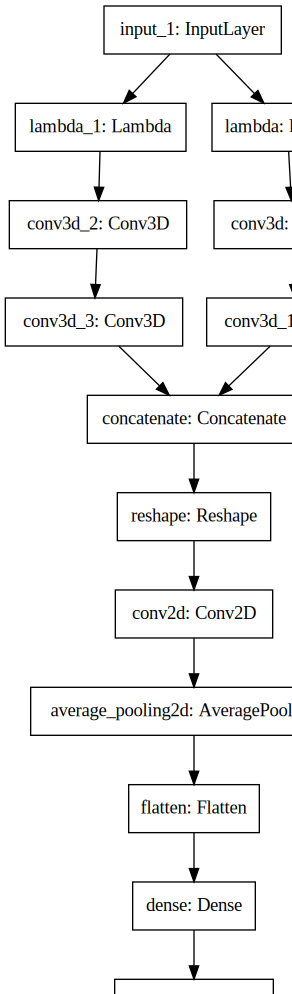

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [ ]:
# compiling the model
adam = Adam(lr=0.001, decay=1e-06)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



In [ ]:
# checkpoint
filepath = "/content/drive/My Drive/Data3/DCT_HOG_Best-model.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
import time
start=time.time() #Find Start Time
history = model.fit(x=Xtrain, y=ytrain, batch_size=64, epochs=100, callbacks=callbacks_list,validation_split=0.15)
end=time.time() #Find End time

Epoch 1/100
41/41 [==============================] - 22s 55ms/step - loss: 2.5629 - accuracy: 0.1698 - val_loss: 2.2321 - val_accuracy: 0.2251

Epoch 00001: accuracy improved from -inf to 0.20482, saving model to /content/drive/My Drive/Data3/DCT_HOG_Best-model.hdf5
Epoch 2/100
41/41 [==============================] - 1s 31ms/step - loss: 2.1196 - accuracy: 0.2898 - val_loss: 1.4864 - val_accuracy: 0.4805

Epoch 00002: accuracy improved from 0.20482 to 0.33346, saving model to /content/drive/My Drive/Data3/DCT_HOG_Best-model.hdf5
Epoch 3/100
41/41 [==============================] - 1s 31ms/step - loss: 1.4678 - accuracy: 0.4985 - val_loss: 0.8825 - val_accuracy: 0.7835

Epoch 00003: accuracy improved from 0.33346 to 0.53560, saving model to /content/drive/My Drive/Data3/DCT_HOG_Best-model.hdf5
Epoch 4/100
41/41 [==============================] - 1s 31ms/step - loss: 0.8790 - accuracy: 0.7192 - val_loss: 0.4361 - val_accuracy: 0.8420

Epoch 00004: accuracy improved from 0.53560 to 0.762

In [ ]:
# load best weights
model.load_weights("/content/drive/My Drive/Data3/DCT_HOG_Best-model.hdf5")
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [ ]:
Xtest = Xtest.reshape(-1, windowSize, windowSize, 30, 1)
Xtest.shape

(7175, 25, 25, 30, 1)

In [ ]:
ytest = np_utils.to_categorical(ytest)
ytest.shape

(7175, 16)

In [ ]:
Y_pred_test = model.predict(Xtest)
y_pred_test = np.argmax(Y_pred_test, axis=1)

classification = classification_report(np.argmax(ytest, axis=1), y_pred_test)
print(classification)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        32
           1       0.99      1.00      0.99      1000
           2       0.99      0.99      0.99       581
           3       0.97      1.00      0.99       166
           4       0.99      0.99      0.99       338
           5       0.99      1.00      0.99       511
           6       1.00      0.90      0.95        20
           7       1.00      1.00      1.00       335
           8       1.00      1.00      1.00        14
           9       1.00      0.99      1.00       680
          10       1.00      0.99      1.00      1719
          11       1.00      0.99      1.00       415
          12       1.00      0.99      1.00       143
          13       1.00      1.00      1.00       886
          14       1.00      1.00      1.00       270
          15       0.98      1.00      0.99        65

    accuracy                           0.99      7175
   macro avg       0.99   

In [ ]:
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

In [ ]:
def reports (X_test,y_test,name):
    start2 = time.time()
    Y_pred = model.predict(X_test)
    y_pred = np.argmax(Y_pred, axis=1)
    end2 = time.time()
    print(end2 - start2)
    if name == 'IP':
        target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
                        ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed', 
                        'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
                        'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
                        'Stone-Steel-Towers']
    elif name == 'SA':
        target_names = ['Brocoli_green_weeds_1','Brocoli_green_weeds_2','Fallow','Fallow_rough_plow','Fallow_smooth',
                        'Stubble','Celery','Grapes_untrained','Soil_vinyard_develop','Corn_senesced_green_weeds',
                        'Lettuce_romaine_4wk','Lettuce_romaine_5wk','Lettuce_romaine_6wk','Lettuce_romaine_7wk',
                        'Vinyard_untrained','Vinyard_vertical_trellis']
    elif name == 'PU':
        target_names = ['Asphalt','Meadows','Gravel','Trees', 'Painted metal sheets','Bare Soil','Bitumen',
                        'Self-Blocking Bricks','Shadows']
    
    classification = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names)
    oa = accuracy_score(np.argmax(y_test, axis=1), y_pred)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)
    score = model.evaluate(X_test, y_test, batch_size=32)
    Test_Loss =  score[0]*100
    Test_accuracy = score[1]*100
    
    return classification, confusion, Test_Loss, Test_accuracy, oa*100, each_acc*100, aa*100, kappa*100

In [ ]:
classification, confusion, Test_loss, Test_accuracy, oa, each_acc, aa, kappa = reports(Xtest,ytest,dataset)
classification = str(classification)
confusion = str(confusion)
file_name = "/content/drive/My Drive/Data3/DCT_HOG_classification_report.txt"

with open(file_name, 'w') as x_file:
    x_file.write('{} Test loss (%)'.format(Test_loss))
    x_file.write('\n')
    x_file.write('{} Test accuracy (%)'.format(Test_accuracy))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{} Kappa accuracy (%)'.format(kappa))
    x_file.write('\n')
    x_file.write('{} Overall accuracy (%)'.format(oa))
    x_file.write('\n')
    x_file.write('{} Average accuracy (%)'.format(aa))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write('{}'.format(confusion))
    x_file.write('\n')
    x_file.write('Time taken for training: {:.2f}s'.format(end-start))

1.2080481052398682
225/225 [==============================] - 3s 6ms/step - loss: 0.0233 - accuracy: 0.9946


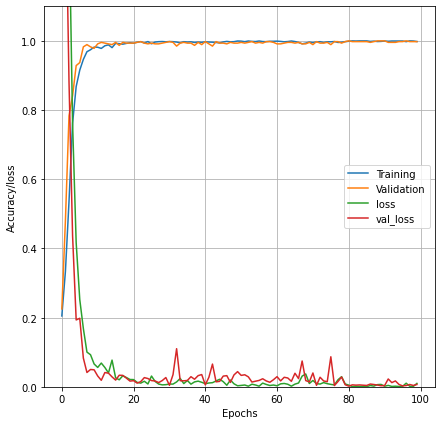

In [ ]:
plt.figure(figsize=(7,7))
plt.ylim(0,1.1)
plt.grid()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Accuracy/loss')
plt.xlabel('Epochs')
plt.legend(['Training','Validation','loss','val_loss'])
plt.savefig("/content/drive/My Drive/Data3/acc_curve_main_GPU.pdf")
plt.show()

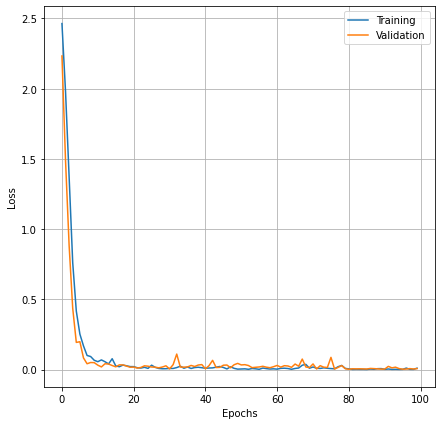

In [ ]:
plt.figure(figsize=(7,7))
plt.grid()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training','Validation'], loc='upper right')
plt.savefig("/content/drive/My Drive/Data3/loss_curve_main_GPU.pdf")
plt.show()

In [ ]:
#plt.plot(trained_model_[0].history['loss'][1:], label='Train loss', c='orange')
#plt.plot(trained_model_[0].history['val_loss'][0:], label='Validation loss', c='blue')
#plt.plot(trained_model_[0].history['loss'][2:], label='Validation loss', c='blue')
#plt.plot(trained_model_[0].history['val_loss'], label='Train loss', c='red')
#plt.axvline(x=213, c='gray', linestyle = '--')
#plt.title('Model loss for SalinasA')
#plt.ylabel('Loss')
#plt.xlabel('Epoch')
#plt.legend()
#plt.savefig('Validation loss except for SalinasA.png', dpi=100)
#plt.show()

In [ ]:
def Patch(data,height_index,width_index):
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]
    
    return patch

In [ ]:
# load the original image
X, y = loadData(dataset)
X.shape,y.shape

((145, 145, 200), (145, 145))

In [ ]:
height = y.shape[0]
width = y.shape[1]
PATCH_SIZE = windowSize
numComponents = 15

In [ ]:
X,pca = applyPCA(X, numComponents=numComponents)

In [ ]:
#Binarization of image
X2=np.zeros(X.shape)
X2[:,:,:]=X[:,:,:]
bimage2 = (255*(X2 - np.min(X2))/np.ptp(X2)).astype(int)   
th2=np.sum(bimage2)//(145*145*15)
bimage2= np.where(bimage2 >= th2, 1, 0)

for i in range(15):
  Xtemp2 = bimage2[:,:,i]
  (hog_desc2, hog_image2) = feature.hog(Xtemp2, orientations=9, pixels_per_cell=(2, 2),
                                      cells_per_block=(8, 8), transform_sqrt=True, block_norm='L2-Hys', visualize=True)
  hog_image_temp2=np.reshape(hog_image2, (145, 145, 1))
  X = np.concatenate((X, hog_image_temp2), axis=2)
  print(hog_image_temp2.shape,X.shape)

#import matplotlib.pyplot as plt
#_, axes = plt.subplots(2, 5, figsize=(30,20))
#axes = axes.flatten()
#for i in range(10):
#  axes[i].imshow(bimage2[:,:,i])



(145, 145, 1) (145, 145, 16)
(145, 145, 1) (145, 145, 17)
(145, 145, 1) (145, 145, 18)
(145, 145, 1) (145, 145, 19)
(145, 145, 1) (145, 145, 20)
(145, 145, 1) (145, 145, 21)
(145, 145, 1) (145, 145, 22)
(145, 145, 1) (145, 145, 23)
(145, 145, 1) (145, 145, 24)
(145, 145, 1) (145, 145, 25)
(145, 145, 1) (145, 145, 26)
(145, 145, 1) (145, 145, 27)
(145, 145, 1) (145, 145, 28)
(145, 145, 1) (145, 145, 29)
(145, 145, 1) (145, 145, 30)


In [ ]:
#import matplotlib.pyplot as plt
#_, axes = plt.subplots(4, 5, figsize=(30,20))
#axes = axes.flatten()
#for i in range(20):
#    axes[i].imshow(X[:,:,i])

In [ ]:
X.shape

(145, 145, 30)

In [ ]:
#X[:,:,0:10]=dctn(X[:,:,0:10])

In [ ]:
X = padWithZeros(X, PATCH_SIZE//2)
X.shape

(169, 169, 30)

In [ ]:
#import matplotlib.pyplot as plt
#_, axes = plt.subplots(4, 5, figsize=(30,20))
#axes = axes.flatten()
#for i in range(20):
#    axes[i].imshow(X[:,:,i])

In [ ]:
# calculate the predicted image
outputs = np.zeros((height,width))
for i in range(height):
    for j in range(width):
        target = int(y[i,j])
        if target == 0 :
            continue
        else :
            image_patch=Patch(X,i,j)
            X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1).astype('float32')
            X_test_image[0,:,:,:15,0]=dctn(X_test_image[0,:,:,:15,0])                                   
            prediction = (model.predict(X_test_image))
            prediction = np.argmax(prediction, axis=1)
            outputs[i][j] = prediction+1

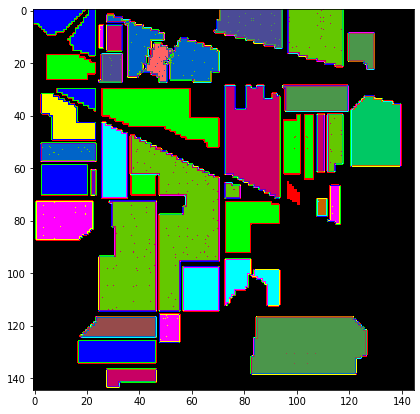

In [ ]:
ground_truth = spectral.imshow(classes = y,figsize =(7,7))

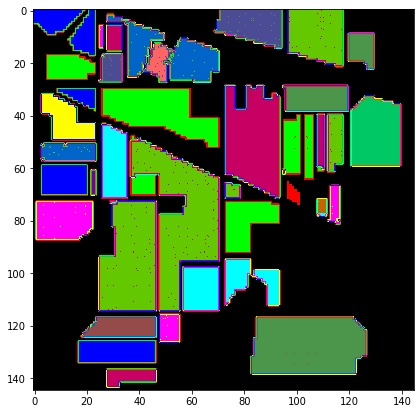

In [ ]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(7,7))

In [ ]:
spectral.save_rgb("/content/drive/My Drive/Data3/DCT_predictions.jpg", outputs.astype(int), colors=spectral.spy_colors)

In [ ]:
spectral.save_rgb(str(dataset)+"_ground_truth508_PU1.jpg", y, colors=spectral.spy_colors)

In [ ]:
print("Time taken for training: {:.2f}s".format(end-start)) #Calculate Time taken for training

Time taken for training: 154.00s
